In [1]:
# basic imports
import random
import numpy as np
import os
import sys

# DL library imports
import torch
import segmentation_models_pytorch as smp
# import torch.nn as nn
# import torch.nn.functional as F

# libraries for loading image, plotting 
# import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
model_dir = '/home/j/j_sten07/palma_models'
# model_name = 'UNet_baseline_last.pt'
# model_name = 'segformer_30epochs_jaccardloss_0.0003lr_best.pt'
# model1_name = 'unet_50epochs_jaccardloss_0.0003lr_8batches_last.pt'
# model1_label = 'UNET'
model1_name = '../thesis_test/output/segformer-mit-b2_test/segformer-mit-b2_test_last.pt'
model1_label = 'Segformer mit-b2'
# model1_name = 'segformer_20epochs_jaccardloss_0.0003lr_4batches_last.pt'
# model1_label = 'segformer 4 batches'
# model2_name = 'unet_50epochs_jaccardloss_0.0003lr_lrschedulerTrue_8batches_last.pt'
# model2_label = 'UNET scheduler'
model2_name = 'segformer_50epochs_jaccardloss_0.0003lr_8batches_last.pt'
model2_label = 'Segformer'
data_path = '/home/j/j_sten07/thesis_test/data/Potsdam/patches/500px'

In [3]:
# load dataset and create data loader
sys.path.append('..')
from utils import make_loader, load_datasets
train_dataset, val_dataset, test_dataset = load_datasets(data_path)
train_loader, val_loader, test_loader = make_loader(train_dataset, val_dataset, test_dataset)

In [4]:
from utils import IoU                  # metric class
from utils import evaluate_model

import sys
# from models import UNet, UNetEncoder, UNetDecoder

In [5]:
# load model
MODEL1_PATH = os.path.join(model_dir, model1_name)
checkpoint1 = torch.load(MODEL1_PATH)
model1 = checkpoint1['model']

MODEL2_PATH = os.path.join(model_dir, model2_name)
checkpoint2 = torch.load(MODEL2_PATH)
model2 = checkpoint2['model']

In [6]:
total_params1 = sum(p.numel() for p in model1.parameters())
print(f"Number of parameters 2: {total_params1} ({model1_label})")
total_params2 = sum(p.numel() for p in model2.parameters())
print(f"Number of parameters 1: {total_params2} ({model2_label})")
# trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)

Number of parameters 2: 24723654 (Segformer mit-b2)
Number of parameters 1: 44599494 (Segformer)


In [7]:
# Evaluation settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)
NUM_CLASSES = 6

In [8]:
from matplotlib.dates import DateFormatter, date2num
myFmt = DateFormatter("%M:%S")

def plot_training_results(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    ax3 = ax1.twinx()  
    ax3.set_ylabel('trainingTime(sec)', color='tab:orange', labelpad=-32)
    # ax3.yaxis.set_major_formatter(myFmt)
    ax3.tick_params(axis="y",direction="in", pad=-23)
    ax3.plot(df['epoch'].values, df['duration_train'].dt.total_seconds(), color='tab:orange')
    ax3.tick_params(axis='y', labelcolor='tab:orange')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()


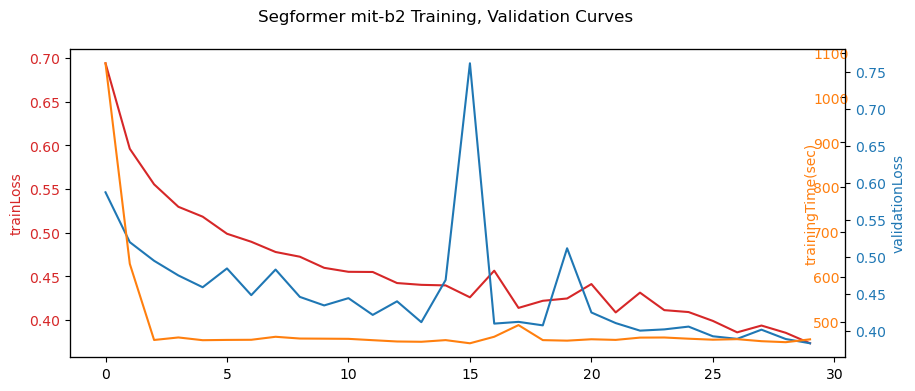

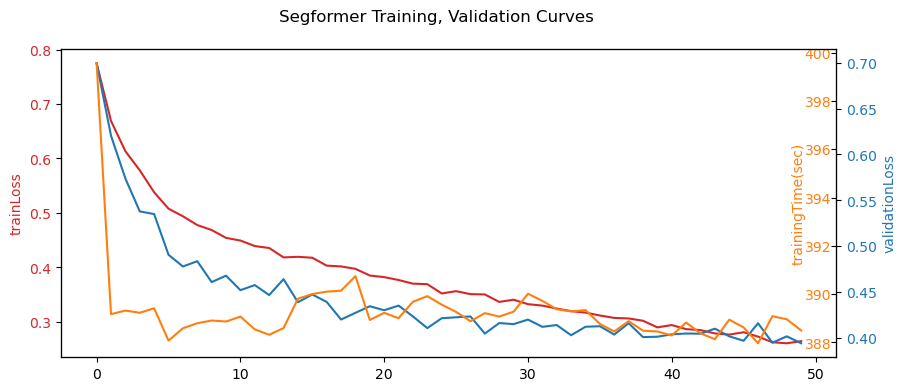

In [9]:
# from utils import plot_training_results

results_df1 = pd.DataFrame(checkpoint1['results'])
plot_training_results(results_df1, model1_label)

results_df2 = pd.DataFrame(checkpoint2['results'])
plot_training_results(results_df2, model2_label)

In [10]:
# torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


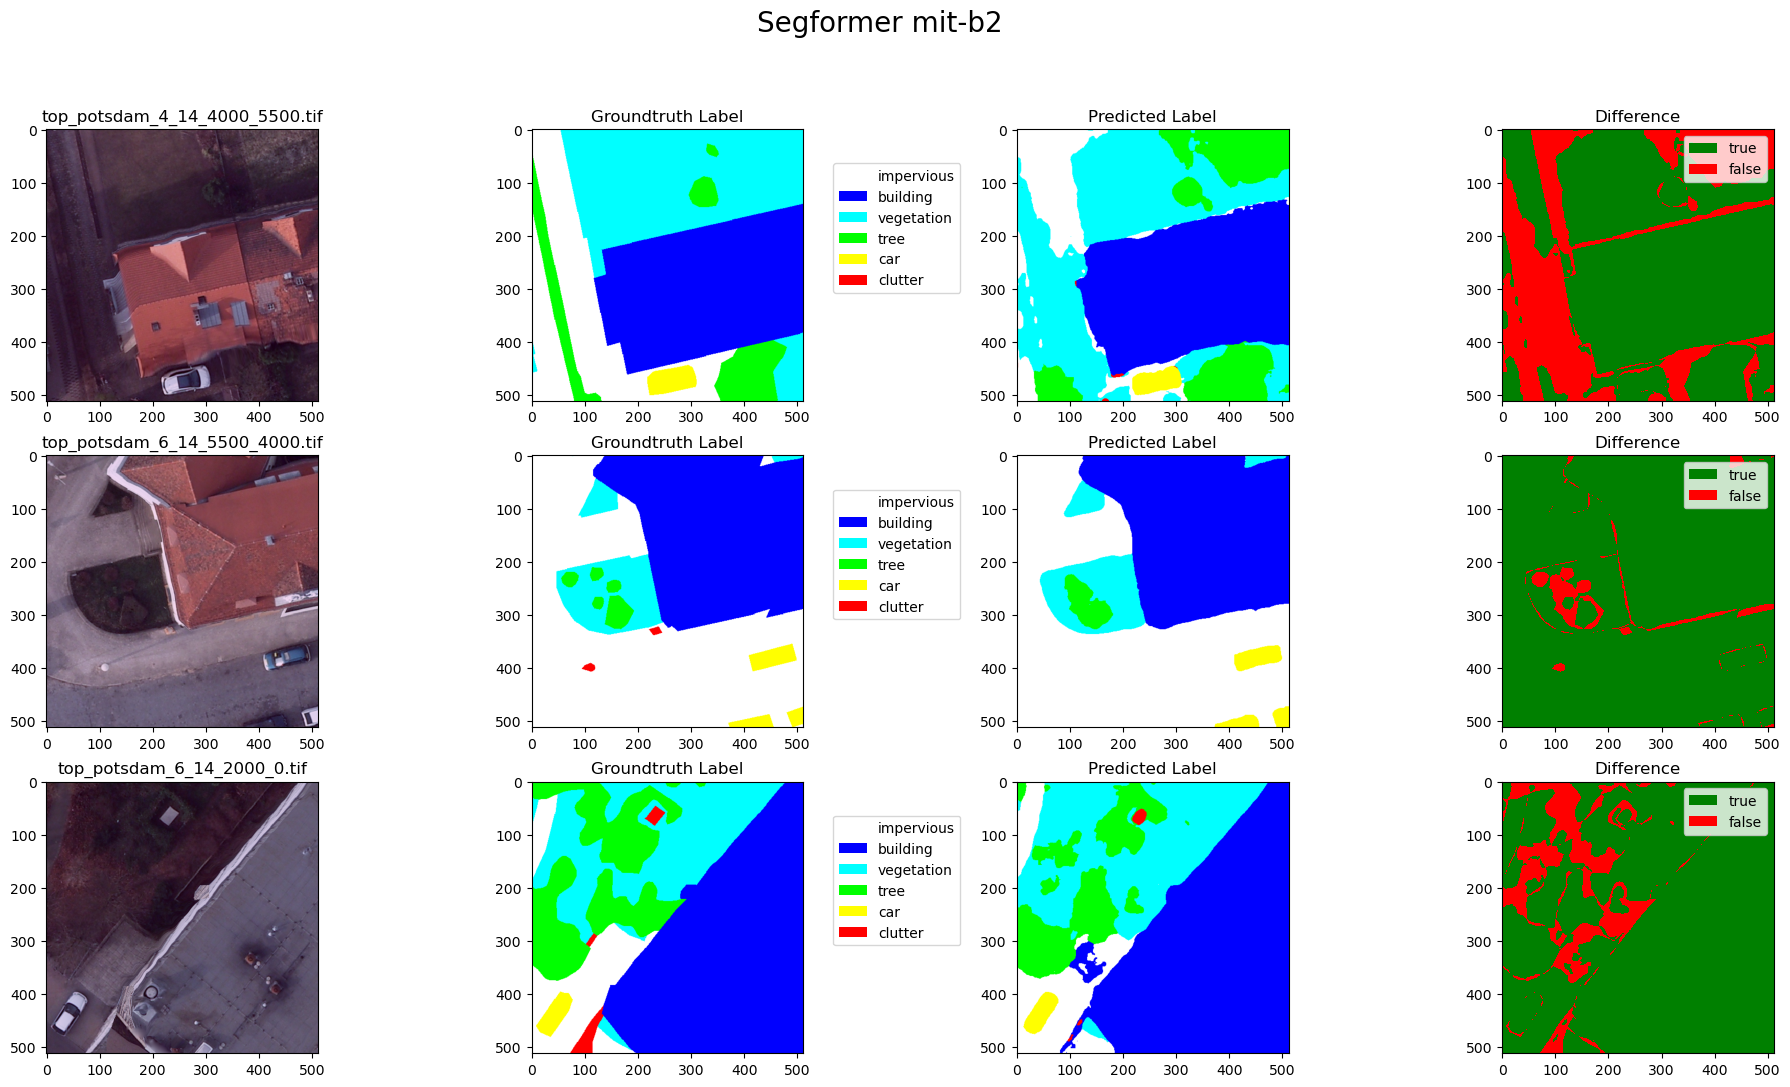

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


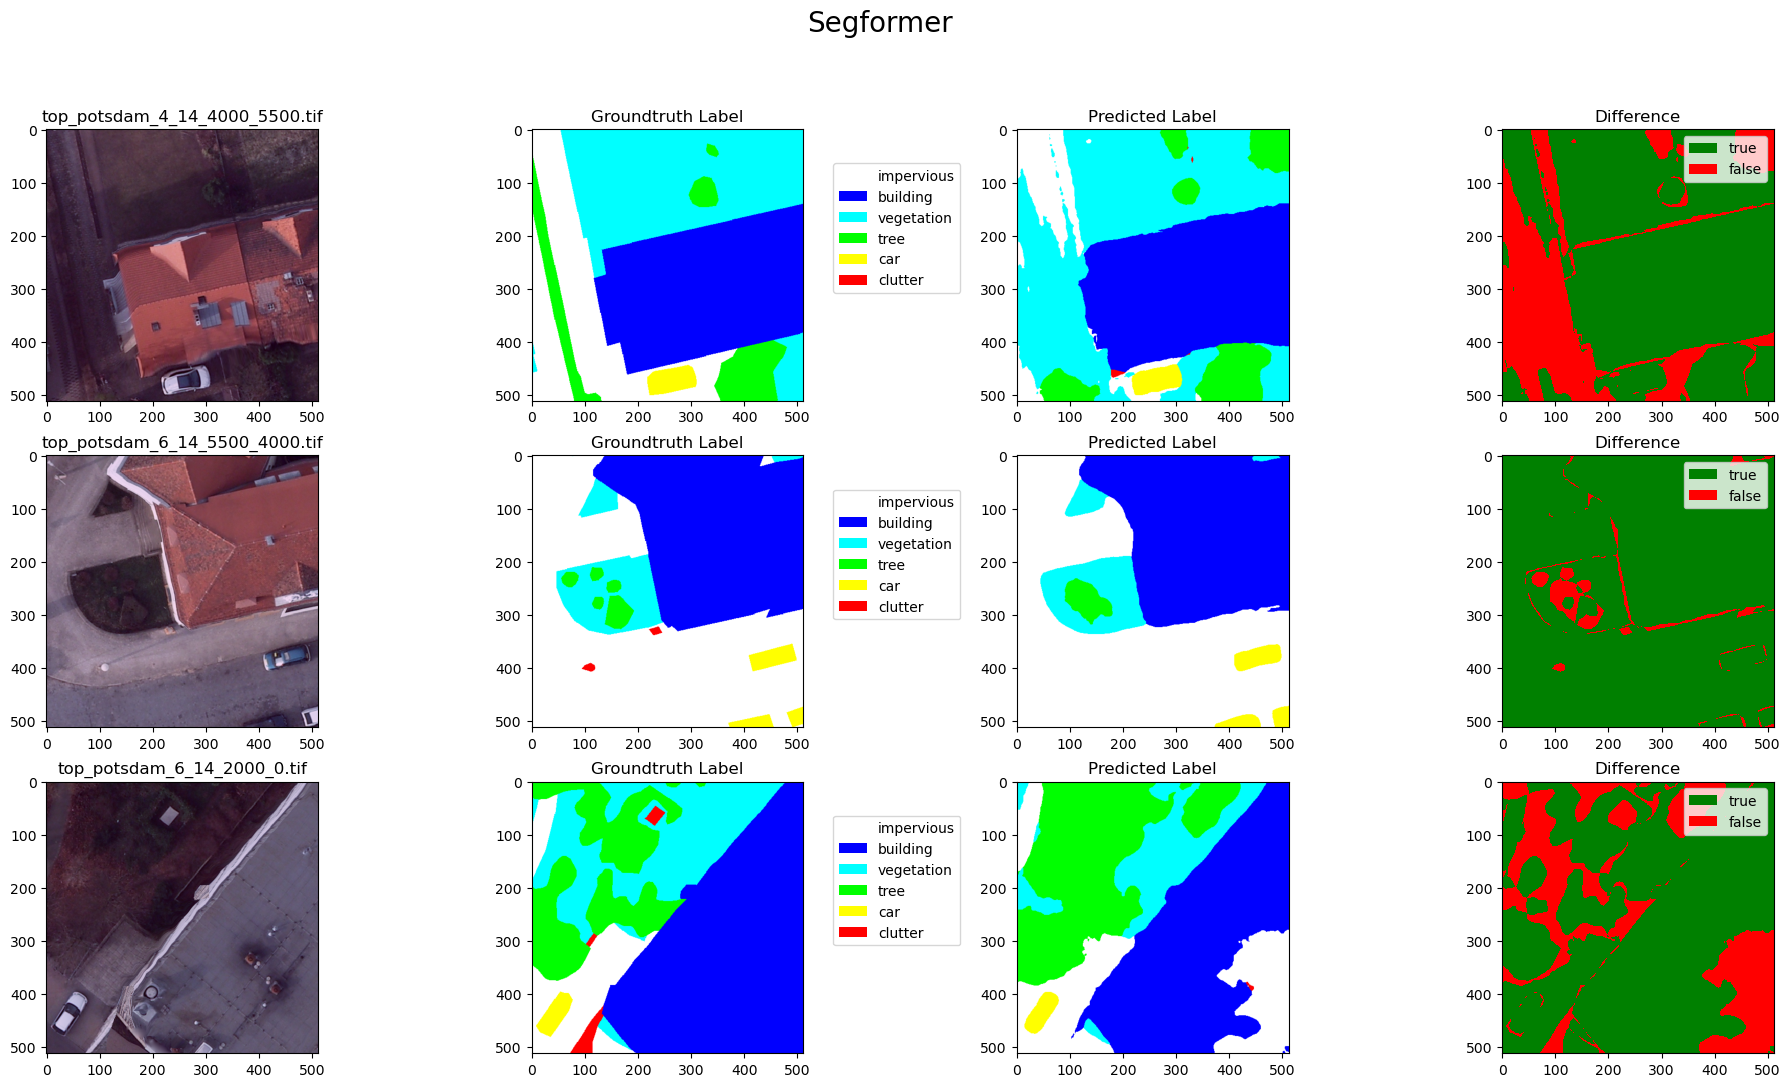

In [11]:
# plot test predictions
from utils import visualize_predictions, train_id_to_color, drivables

num_test_samples = 3
seed = 43
_, axes1 = plt.subplots(num_test_samples, 4, figsize=(4*6, num_test_samples * 4))
_.suptitle(model1_label, fontsize=20)
visualize_predictions(model1, test_dataset, axes1, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color, seed = seed)
_, axes2 = plt.subplots(num_test_samples, 4, figsize=(4*6, num_test_samples * 4))
_.suptitle(model2_label, fontsize=20)
visualize_predictions(model2, test_dataset, axes2, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color, seed = seed)

In [12]:
# evaluate model performance on test dataset
_, test_metric1 = evaluate_model(model1, test_loader, criterion, IoU, NUM_CLASSES, device)
# print(f"\nModel has {test_metric1} metrices in test set")
_, test_metric2 = evaluate_model(model2, test_loader, criterion, IoU, NUM_CLASSES, device)
# print(f"\nModel has {test_metric1} metrices in test set")

100%|██████████| 360/360 [01:40<00:00,  3.58it/s]


In [13]:
# 1. Run model on test dataset
# 2. Visualize matrix

In [14]:
def create_resultstable(metrices):
    # get matrix from results
    # results = results_df.metrices[len(results_df)-1] 
    results = metrices
    matrix = results['matrix']
    # calculate recall and respective values for wrong segmentations
    matrix_per = matrix / matrix.sum(axis = 1)[np.newaxis].T # transpose sum to apply divison to rows
    recall = np.diag(matrix_per)
    # other metrices
    precision = np.diag(matrix / matrix.sum(axis = 0))
    f1 = 2*precision*recall / (precision+recall)
    
    # classes as captions for table
    CLASSES = ['impervious', 'building', 'vegetation', 'tree', 'car', 'clutter']
    
    # make df and add column names and ids
    df = pd.DataFrame(matrix_per)
    df.columns = [s + '_pred' for s in CLASSES]
    df.index = [s + '_tr' for s in CLASSES]
    # add metrices
    df.loc['Precision'] = precision
    df.loc['Recall'] = recall
    df.loc['f1'] = f1
    df.loc['IoU'] = results['classwise_iou']
    
    # print('Metrices')
    print(f'Accuracy: {results["accuracy"]}, MeanIoU: {results["miou"]}') 
          #, f1 score mean: {results["f1_mean"]}')
    print('"row predicted as column"')
    display(df)

In [15]:
# metrices on test data
print(f'{model1_label} ({len(results_df1)} epochs)')
create_resultstable(test_metric1)
print(f'{model2_label} ({len(results_df2)} epochs)')
create_resultstable(test_metric2)

Segformer mit-b2 (30 epochs)
Accuracy: 0.810118473900689, MeanIoU: 0.6399052661134835
"row predicted as column"


,impervious_pred,building_pred,vegetation_pred,tree_pred,car_pred,clutter_pred
impervious_tr,0.877238,0.031554,0.046219,0.019888,0.003361,0.021741
building_tr,0.060692,0.920955,0.008392,0.003457,0.000656,0.005848
vegetation_tr,0.054472,0.014622,0.835823,0.069830,0.000116,0.025138
tree_tr,0.050771,0.007952,0.223369,0.692468,0.002786,0.022655
car_tr,0.071102,0.016956,0.006770,0.016975,0.850503,0.037693
clutter_tr,0.307312,0.194521,0.124306,0.044607,0.004941,0.324314
Precision,0.809341,0.893972,0.759990,0.850959,0.894199,0.443766
Recall,0.877238,0.920955,0.835823,0.692468,0.850503,0.324314
f1,0.841923,0.907263,0.796105,0.763576,0.871804,0.374751
IoU,0.727001,0.830267,0.661274,0.617568,0.772741,0.230581


Segformer (50 epochs)
Accuracy: 0.8076200167338053, MeanIoU: 0.6313558688638586
"row predicted as column"


,impervious_pred,building_pred,vegetation_pred,tree_pred,car_pred,clutter_pred
impervious_tr,0.873381,0.034412,0.048157,0.027808,0.004438,0.011804
building_tr,0.041877,0.939568,0.006600,0.003986,0.000793,0.007175
vegetation_tr,0.051104,0.019581,0.811751,0.105427,0.000332,0.011806
tree_tr,0.050968,0.013590,0.213988,0.707536,0.004162,0.009756
car_tr,0.072197,0.016313,0.008724,0.012928,0.876869,0.012969
clutter_tr,0.311988,0.203069,0.155953,0.057482,0.011540,0.259968
Precision,0.822058,0.881408,0.755701,0.800762,0.851653,0.548715
Recall,0.873381,0.939568,0.811751,0.707536,0.876869,0.259968
f1,0.846943,0.909559,0.782724,0.751268,0.864077,0.352792
IoU,0.734519,0.834121,0.643012,0.601624,0.760683,0.214176


In [16]:
# metrices on validation data
print(f'{model1_label} ({len(results_df1)} epochs)')
create_resultstable(checkpoint1['results'][-1]['metrices'])
print(f'{model2_label} ({len(results_df2)} epochs)')
create_resultstable(checkpoint2['results'][-1]['metrices'])

Segformer mit-b2 (30 epochs)
Accuracy: 0.8336305194430881, MeanIoU: 0.6379416282988591
"row predicted as column"


,impervious_pred,building_pred,vegetation_pred,tree_pred,car_pred,clutter_pred
impervious_tr,0.871528,0.041876,0.044563,0.025229,0.002101,0.014703
building_tr,0.046414,0.920491,0.018494,0.007272,0.000292,0.007036
vegetation_tr,0.040098,0.013482,0.855356,0.078825,0.000069,0.012171
tree_tr,0.065825,0.011092,0.174907,0.726277,0.002302,0.019597
car_tr,0.088453,0.014049,0.005338,0.016132,0.844958,0.031071
clutter_tr,0.340961,0.228885,0.154981,0.073572,0.008893,0.192709
Precision,0.855222,0.904035,0.782690,0.803522,0.914500,0.330320
Recall,0.871528,0.920491,0.855356,0.726277,0.844958,0.192709
f1,0.863298,0.912189,0.817411,0.762950,0.878355,0.243411
IoU,0.759476,0.838555,0.691205,0.616749,0.783095,0.138570


Segformer (50 epochs)
Accuracy: 0.821308766471015, MeanIoU: 0.6135933927666276
"row predicted as column"


,impervious_pred,building_pred,vegetation_pred,tree_pred,car_pred,clutter_pred
impervious_tr,0.859746,0.051780,0.045650,0.030020,0.002913,0.009891
building_tr,0.040473,0.929402,0.013465,0.008594,0.000954,0.007112
vegetation_tr,0.043602,0.021963,0.836197,0.088177,0.000254,0.009807
tree_tr,0.076060,0.019195,0.200425,0.692453,0.003589,0.008277
car_tr,0.102279,0.017036,0.005215,0.010072,0.849820,0.015579
clutter_tr,0.355513,0.218263,0.178744,0.067790,0.025125,0.154564
Precision,0.848863,0.885076,0.765723,0.776828,0.852659,0.368711
Recall,0.859746,0.929402,0.836197,0.692453,0.849820,0.154564
f1,0.854270,0.906697,0.799410,0.732218,0.851237,0.217818
IoU,0.745612,0.829320,0.665847,0.577558,0.741004,0.122220
